In [1]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [10]:
coco_dataset_path = "/home/kafkaon1/Dev/data/COCO_0503/train_imgs"
coco = COCO('/home/kafkaon1/Dev/data/COCO_0503/annotations_train.json')

ann_ids = coco.getAnnIds(iscrowd=False)
anns = coco.loadAnns(ann_ids)
anns = [ann for ann in anns if len(ann['segmentation']) > 0]


loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


BBox[0] (xyxy): [713.0, 168.0, 1081.0, 323.0]
/home/kafkaon1/Dev/data/COCO_0503/train_imgs/20230630_164906.jpg
(1, 194, 2)


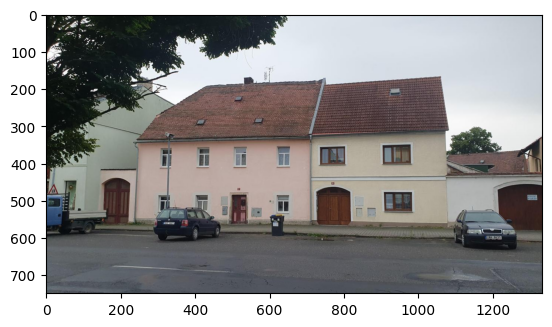

In [103]:

for i, ann in enumerate(anns[100:]):
    image_id = ann["image_id"]
    segs = ann["segmentation"]
    bbox = np.array(ann["bbox"])
    bbox[2:4] = bbox[0:2] + bbox[2:4]
    print("BBox[{}] (xyxy):".format(i), bbox.tolist())
    
    image_info = coco.loadImgs(image_id)
    image_path = image_info[0]["file_name"]
    # [0] is required, always return a list
    image_path = os.path.join(coco_dataset_path, image_path)
    print(image_path)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segs = [np.array(seg, np.int32).reshape((1, -1, 2))
            for seg in segs]
    print(segs[0].shape)
#     for seg in segs: cv2.drawContours(image, seg, -1, (0,255,0), 2)
    # third aug -1 means draw all contours in 3-D array, Or
    # for seg in segs: cv2.fillPoly(image, segm, (0,255,0))
    # cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), 
    #               (int(bbox[2]), int(bbox[3])), (0,0,255), 2)
    plt.imshow(image)

    break

In [13]:
image.shape

(749, 1333, 3)

In [108]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

# load images test_r.png and test_t.png and display them
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid

import torch
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
import models

register_all_modules()

models_mask = {
    'point_rend': ('/home/kafkaon1/Dev/mmdetection/configs/point_rend/point-rend_r101-caffe_fpn_ms-3x_roofs.py', '/home/kafkaon1/Dev/out/pointRendOut1012/epoch_20.pth')
}

model_name = 'point_rend'
model = init_detector(*models_mask[model_name], device='cuda:1') 

ckpt = torch.load('/home/kafkaon1/Dev/out/train/SolAR_KPdet/0323_091757/best_ckpt_ep21.pth', map_location='cuda:0')
model_ref = models.MaxVitUnet(logits=False)
model_ref.load_state_dict(ckpt['state_dict'])

Loads checkpoint by local backend from path: /home/kafkaon1/Dev/out/pointRendOut1012/epoch_20.pth


<All keys matched successfully>

In [134]:
image = cv2.imread('/home/kafkaon1/Dev/FVAPP/demos/sch1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [135]:
min_area_threshold=4000
arc_length_coeff=0.005
PATCH_SIZE = 256


In [136]:
res = inference_detector(model, image)
            
estimate_points = []
# go through all masks -> check if are roofs -> polygonize -> collect are polygon points
for i, mask in enumerate(res.pred_instances['masks'][0:]):
    if res.pred_instances['scores'][i] < 0.5:
        continue
    
    if res.pred_instances['labels'][i] != 0:
        continue
    
    if mask.sum() < 1:
        continue
    
    polygon_vertices = None
    mask = mask.cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        epsilon = arc_length_coeff * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        area = cv2.contourArea(approx)

        if len(approx) >= 3 and area > min_area_threshold:
            polygon_vertices = approx.reshape(-1, 2).astype(np.float32)
            estimate_points += [*polygon_vertices]
            
    break

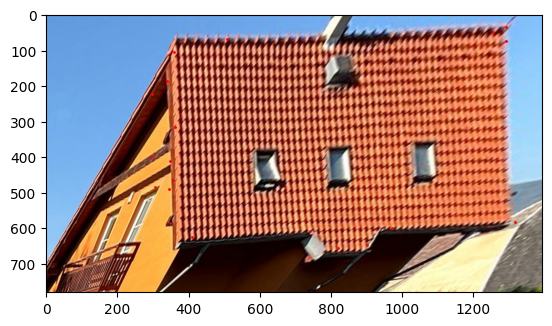

In [139]:
plt.imshow(image)
estimate_points = np.array(estimate_points)
plt.scatter(estimate_points[:, 0], estimate_points[:, 1], c='r', s=1)

In [251]:
import torch.nn as nn

class CornerRefiner(nn.Module):
    def __init__(self, ckpt_path, device='cuda:0', noise_thr=0.1, conf_thr=0.2, dst_thr=10):
        '''
            ckpt_path : path to the checkpoint of the model
            device : device to run the model on
            noise_thr : threshold under which everything in keypoint heatmap is regarder as noise
            conf_thr : threshold above which every heatmap local maximum is regarded as new keypoint
            dst_thr : threshold for the distance between the refined keypoint and the original point
        '''
        super(CornerRefiner, self).__init__()
        self.model = models.MaxVitUnet(logits=False)
        ckpt = torch.load(ckpt_path, map_location=device)
        self.model.load_state_dict(ckpt['state_dict'])
        self.noise_thr = noise_thr
        self.conf_thr = conf_thr
        
    
    def forward(self, img, roof_polygon):
        '''
            img : np.array of shape (H, W, 3)
            roof_polygon : polygonized roof mask to be refined
            
            returns : refined polygon
        '''
        thr = 0.1
        out_polygon = []
        for pt in roof_polygon:
            patch, offset = get_patch(image, *pt) # get patch around the point and the offset of the point in the patch
            patch = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).float()/255
            out = model_ref(patch)
            
            sc, indi = get_keypoint_coords(out, self.noise_thr)
            ind = indi[0] # as there is no batch approach imlpemented yet
            dists = torch.pow(ind - np.array(offset), 2).sum(axis=1)
            
            # closest keypoint
            dst = torch.min(dists)
            
            score = sc[0][torch.argmin(dists)]
            if score > thr and dst < 10:
                indc = ind[torch.argmin(dists)]
                out_polygon.append(indc)
            
        
def get_patch(img, x, y):
    # create 256x256 patch with the point in the middle from img with prevence against overflowing
    
    x_ = x if x >= PATCH_SIZE//2 else PATCH_SIZE//2
    y_ = y if y >= PATCH_SIZE//2 else PATCH_SIZE//2
    x_ = x if x <= img.shape[1] - PATCH_SIZE//2 else img.shape[1] - PATCH_SIZE//2
    y_ = y if y <= img.shape[0] - PATCH_SIZE//2 else img.shape[0] - PATCH_SIZE//2
    x_ = int(x_)
    y_ = int(y_)
    
    # offset of the point in the patch
    xo = x - x_ + PATCH_SIZE//2
    yo = y - y_ + PATCH_SIZE//2
    
    return img[y_-PATCH_SIZE//2:y_+PATCH_SIZE//2, x_-PATCH_SIZE//2:x_+PATCH_SIZE//2], torch.tensor([xo, yo])


def get_keypoint_coords(heatmap, noise_thr):
    '''
        Function for getting the keypoint coordinates from the heatmap,
        it is basically getting local maxima of the heatmap using maxpooling
        TODO - complete batch-based approach
    '''
    min_keypoint_pixel_distance = 3
    
    batch_size, n_channels, _, width = heatmap.shape
    heatmap[heatmap < noise_thr] = 0 # filter noise
    kernel = min_keypoint_pixel_distance * 2 + 1
    pad = min_keypoint_pixel_distance
    # exclude border keypoints by padding with highest possible value
    # bc the borders are more susceptible to noise and could result in false positives
    padded_heatmap = torch.nn.functional.pad(heatmap, (pad, pad, pad, pad), mode="constant", value=0)
    max_pooled_heatmap = torch.nn.functional.max_pool2d(padded_heatmap, kernel, stride=1, padding=0)
    # if the value equals the original value, it is the local maximum
    local_maxima = torch.bitwise_and(max_pooled_heatmap == heatmap, heatmap > 0)
    # all values to zero that are not local maxima
    heatmap = heatmap * local_maxima
    num_pts = torch.sum(local_maxima)
    if num_pts == 0: # no local maxima found - topk would complain
        return torch.zeros(batch_size, 0, 1), torch.zeros(batch_size, 0, 2)
    
    # extract top-k from heatmap (may include non-local maxima if there are less peaks than max_keypoints)
    scores, indices = torch.topk(heatmap.view(batch_size, -1), num_pts, sorted=True)
    indices = torch.stack([torch.div(indices, width, rounding_mode="floor"), indices % width], dim=-1)
    return scores, indices

In [252]:
ref = CornerRefiner('/home/kafkaon1/Dev/out/train/SolAR_KPdet/0323_091757/best_ckpt_ep21.pth')

In [254]:
ref(image, estimate_points)

RuntimeError: Calculated padded input size per channel: (2 x 258). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

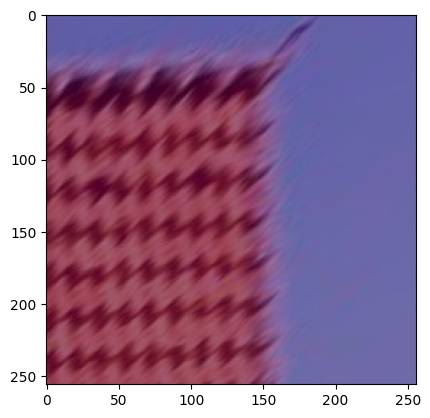

In [163]:
plt.imshow(patch[0].permute(1, 2, 0).detach().cpu())
plt.imshow(out[0][0].detach().cpu(), alpha=0.5)

<All keys matched successfully>

In [130]:
from parse_config import ConfigParser
import argparse
import dataset as data_module   
from utils import read_json, write_json, setup_logging

config = read_json('/home/kafkaon1/Dev/FVAPP/configs/config_kp.json')

config = ConfigParser(config, None)

train_loader = config.init_obj('train_data_loader', data_module)
valid_loader = config.init_obj('val_data_loader', data_module)


In [91]:
ID = 12

In [92]:
tst = valid_loader.dataset[ID][0].unsqueeze(0)
out = model(tst)
out = torch.sigmoid(out)
out.max()

tensor(0.6920, grad_fn=<MaxBackward1>)

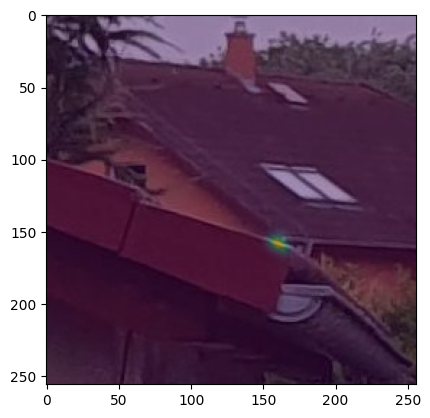

In [93]:
plt.imshow(valid_loader.dataset[ID][0].permute(1,2,0).detach().cpu().numpy())
#plt.imshow(valid_loader.dataset[ID][1][0].detach().cpu().numpy(), alpha = 0.4)
plt.imshow(out[0, 0].detach().cpu().numpy(), alpha = 0.4)